# Panduan Singkat OQ di Python

Jalankan file ini di Openquake yang sudah diinstal di komputer masing-masing.

Masuk ke direktori di Command Prompt tempat file ini disimpan. Contoh:
```
cd C:\Users\USERNAME\Documents
```

Lalu, jalankan jupyter notebook di direktori tersebut pada Command Prompt. Contoh:
```
"C:\Program Files\Openquake Engine\python3.6\Scripts\jupyter.exe" notebook
```

## 1. Download data katalog

Download data katalog di sini:

http://isc.ac.uk/iscbulletin/search/catalogue/

lalu susun data katalog tersebut ke dalam format csv berikut ini:
```
eventID,year,month,day,hour,minute,second,longitude,latitude,depth,magnitude,sigmaMagnitude
1451994,1999,02,13,21,46,28.70,102.8258,-4.9794,700,2.1015,0
17198558,2011,03,25,21,44,18.21,109.5132,-5.1621,700,3.71862,0
300154,1992,03,17,19,02,13   ,109.5,-6.5,662,3.3,0
612165570,2018,06,22,20,57,43.65,108.3305,-5.0316,656.4,5.43681,0
484365,1986,10,18,22,09,33.39,109.9477,-5.5495,652.3,5.94216,0
15634840,2010,05,31,15,45,12.82,108.1441,-5.0687,652.1,4.02183,0
...
```

dengan magnitudo dikonversi semua ke dalam Mw (momen magnitudo) berdasarkan konversi PuSGEN 2017:
https://sianipar17.files.wordpress.com/2018/12/nsha_2017.pdf

## 2. Import packages

Hal ini memastikan apakah python yang digunakan sudah menyediakan packages yang dibutuhkan.

In [1]:
from openquake.hmtk.parsers.catalogue import *
from openquake.hmtk.plotting.seismicity.catalogue_plots import *
from openquake.hmtk.seismicity.declusterer.dec_gardner_knopoff import *
from openquake.hmtk.seismicity.declusterer.distance_time_windows import *
from openquake.hmtk.seismicity.selector import *
from openquake.hazardlib.geo.polygon import Polygon as PolyOQ
from openquake.hazardlib.geo.point import Point as PointOQ
from openquake.hazardlib.geo.line import Line as LineOQ
from openquake.hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971
from openquake.hmtk.seismicity.occurrence.b_maximum_likelihood import BMaxLikelihood
from openquake.hmtk.plotting.seismicity.completeness.plot_stepp_1972 import create_stepp_plot
from openquake.hmtk.seismicity.smoothing.smoothed_seismicity import SmoothedSeismicity
from openquake.hmtk.seismicity.smoothing.kernels.isotropic_gaussian import IsotropicGaussian
from openquake.hazardlib.geo.surface.complex_fault import ComplexFaultSurface
from shapely.geometry import *
from shapely.ops import *
import utm
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pickle

## 3. Membaca data katalog dalam format csv

In [2]:
# baca data katalog yang berada di harddisk
catalogue_filename = "katalog-ISC-1964-2021.csv"
parser = CsvCatalogueParser(catalogue_filename)
catalogue = parser.read_file()

### 3.1 Melihat sebaran data berdasarkan waktu kejadian dan magnitudo

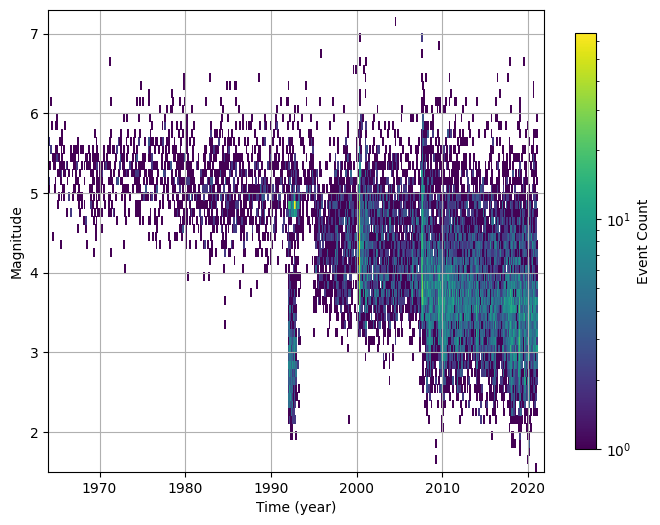

In [3]:
magnitude_bin_width = 0.1
time_bin_width = 0.1
plot_magnitude_time_density (catalogue, magnitude_bin_width, time_bin_width)

### 3.2 Save to pickle variables used by pyGMT

In [5]:
idcs = ['eventID','year','month','day','hour',
       'minute','second','longitude','latitude',
       'depth','magnitude','sigmaMagnitude']

dict_catalogue = dict()
for idx in idcs:
    if isinstance(catalogue[idx], list): 
        dict_catalogue[idx] = catalogue[idx]
    else:
        dict_catalogue[idx] = catalogue[idx].tolist()

with open('dict_catalogue.pkl', 'wb') as file:
    pickle.dump(dict_catalogue, file)

## 4. Declustering

In [6]:
declust_config = {'time_distance_window': UhrhammerWindow() ,
                  'fs_time_prop': 1.0}

declustering = GardnerKnopoffType1()
cluster_index, cluster_flag = declustering.decluster(catalogue, declust_config)

selectorCatalogue = CatalogueSelector(catalogue, create_copy = True)
catalogue_declustered = selectorCatalogue.select_catalogue(cluster_flag == 0)

print("sebelum didekluster: ", len(catalogue['eventID']), " events")
print("setelah didekluster: ", len(catalogue_declustered['eventID']), " events")

sebelum didekluster:  18032  events
setelah didekluster:  12598  events


### 4.1 Save to pickle variables used by pyGMT

In [7]:
idcs = ['eventID','year','month','day','hour',
       'minute','second','longitude','latitude',
       'depth','magnitude','sigmaMagnitude']

dict_catalogue = dict()
for idx in idcs:
    if isinstance(catalogue[idx], list): 
        dict_catalogue[idx] = catalogue_declustered[idx]
    else:
        dict_catalogue[idx] = catalogue_declustered[idx].tolist()

with open('dict_catalogue_declustered.pkl', 'wb') as file:
    pickle.dump(dict_catalogue, file)

### 4.2 Melihat sebaran data berdasarkan waktu kejadian dan magnitudo

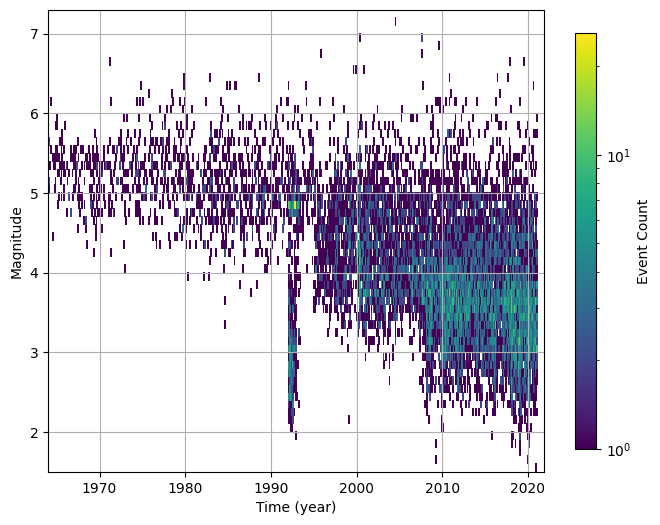

In [8]:
magnitude_bin_width = 0.1
time_bin_width = 0.1
plot_magnitude_time_density (catalogue_declustered, magnitude_bin_width, time_bin_width)

### 4.3 Magnitude of Completeness (Mc)

In [9]:
completeness_algorithm = Stepp1971()

comp_config = {'magnitude_bin': 0.1,
                'time_bin': 5. ,
                'increment_lock': True }

completeness_table_old = completeness_algorithm.completeness(catalogue_declustered, comp_config)
completeness_algorithm.simplify(mag_range=[3., 5.])
completeness_table = completeness_algorithm.completeness_table
Mc_declustered = completeness_table

print("== Keseluruhan Mc ==")
print(completeness_table_old)
print("\n== selected Mc ==")
print(completeness_table)


== Keseluruhan Mc ==
[[2.016e+03 1.400e+00]
 [2.006e+03 1.500e+00]
 [2.006e+03 1.600e+00]
 [2.006e+03 1.700e+00]
 [2.006e+03 1.800e+00]
 [2.006e+03 1.900e+00]
 [2.006e+03 2.000e+00]
 [2.006e+03 2.100e+00]
 [2.006e+03 2.200e+00]
 [2.006e+03 2.300e+00]
 [2.006e+03 2.400e+00]
 [2.006e+03 2.500e+00]
 [2.006e+03 2.600e+00]
 [2.006e+03 2.700e+00]
 [2.006e+03 2.800e+00]
 [2.006e+03 2.900e+00]
 [2.006e+03 3.000e+00]
 [2.006e+03 3.100e+00]
 [2.006e+03 3.200e+00]
 [2.006e+03 3.300e+00]
 [2.006e+03 3.400e+00]
 [2.005e+03 3.500e+00]
 [2.004e+03 3.600e+00]
 [2.002e+03 3.700e+00]
 [1.999e+03 3.800e+00]
 [1.996e+03 3.900e+00]
 [1.996e+03 4.000e+00]
 [1.996e+03 4.100e+00]
 [1.996e+03 4.200e+00]
 [1.996e+03 4.300e+00]
 [1.996e+03 4.400e+00]
 [1.996e+03 4.500e+00]
 [1.990e+03 4.600e+00]
 [1.979e+03 4.700e+00]
 [1.979e+03 4.800e+00]
 [1.979e+03 4.900e+00]
 [1.968e+03 5.000e+00]
 [1.968e+03 5.100e+00]
 [1.968e+03 5.200e+00]
 [1.958e+03 5.300e+00]
 [1.956e+03 5.400e+00]
 [1.956e+03 5.500e+00]
 [1.956e+03 5

### 4.3.1 Plot Mc

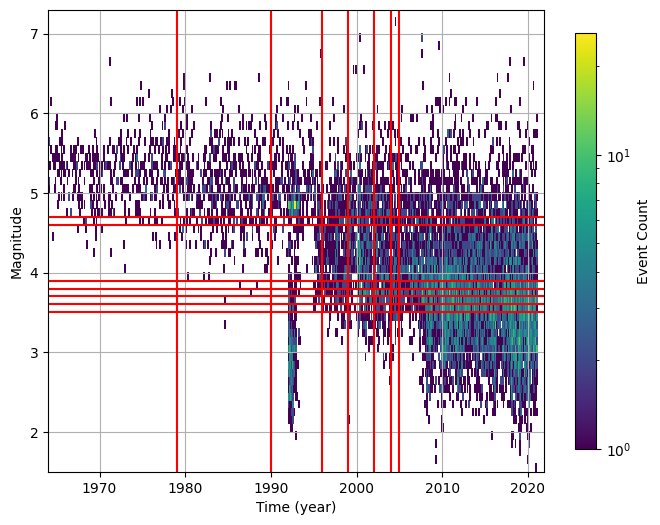

In [10]:
magnitude_bin_width = 0.1
time_bin_width = 0.1
plot_magnitude_time_density (catalogue_declustered, magnitude_bin_width, time_bin_width)
for v, h in zip(completeness_table[:,0],completeness_table[:,1]):
    plt.axvline(v, c="red")
    plt.axhline(h, c="red")

### 4.3.2 Plot Mc di Annual Rate

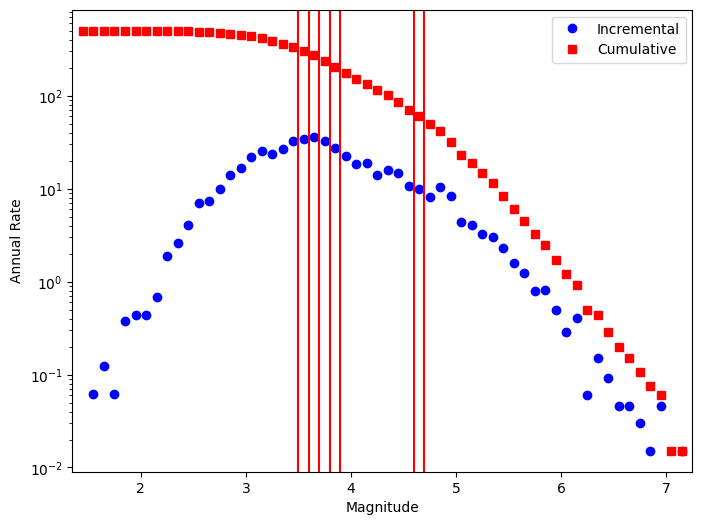

In [11]:
magnitude_bin_width = 0.1
plot_observed_recurrence(catalogue_declustered, completeness_table_old, magnitude_bin_width)
for v in completeness_table[:,1]:
    plt.axvline(v, c="red")

## 5. Sumber Gempa

### 5.1 Patahan/Sesar

#### 5.1.1 Konversi data patahan ke dalam array

In [14]:
# lon lat
txt="""
105.524941802829    -8.71127688943498
105.5    -8.59561634597434
105.4375    -8.4762705564245
105.375    -8.35393314447619
105.25    -8.22852433353212
105.125    -8.15002416179613
104.942927950575    -8.0625
104.662433434494    -7.96131262090033
104.375    -7.90961738585468
104.0625    -7.79665372408826
103.78265711955    -7.6875
103.655440039067    -7.625
103.398213697197    -7.54075699217249
103.170158997736    -7.4375
103.022944583532    -7.36205741423692
102.826375047803    -7.25994336970231
102.66822459172    -7.17068831544382
102.420973415569    -7.01976860304531
"""

# jika delimiter berupa tab maka ubah ke '\t'
delimiter = '    '

def print_array(txt, delimiter):
    txtln = txt.split('\n')
    txtarr = []
    for x in txtln:
        txttemp = [float(t) for t in x.split(delimiter) if t != '']
        if txttemp != []:
            txtarr.append(txttemp)
    print(txtarr)

# execute
print_array(txt, delimiter)

# copy ke variabel
# contoh: fault1 = np.array(<copy di sini>)

[[105.524941802829, -8.71127688943498], [105.5, -8.59561634597434], [105.4375, -8.4762705564245], [105.375, -8.35393314447619], [105.25, -8.22852433353212], [105.125, -8.15002416179613], [104.942927950575, -8.0625], [104.662433434494, -7.96131262090033], [104.375, -7.90961738585468], [104.0625, -7.79665372408826], [103.78265711955, -7.6875], [103.655440039067, -7.625], [103.398213697197, -7.54075699217249], [103.170158997736, -7.4375], [103.022944583532, -7.36205741423692], [102.826375047803, -7.25994336970231], [102.66822459172, -7.17068831544382], [102.420973415569, -7.01976860304531]]


#### 5.1.2 Menggabungkan beberapa patahan

Patahan digabung didasarkan dekatnya posisi antar patahan

In [12]:
# fungsi untuk mengubah data lon lat pada patahan menjadi poligon
def polygon_from_fault(fault_longitude, fault_latitude, distance=20000):
    fault1_utm = utm.from_latlon(np.array(fault_latitude), np.array(fault_longitude))
    input_for_faultLine1 = np.array([fault1_utm[0], fault1_utm[1]]).T.tolist()
    faultLine1 = LineString(input_for_faultLine1)
    dilated = faultLine1.buffer(distance)
    dilated_x, dilated_y = dilated.exterior.xy
    res_lat, res_lon = utm.to_latlon(np.array(dilated_x.tolist()), np.array(dilated_y.tolist()), fault1_utm[2], fault1_utm[3])
    return res_lon, res_lat

# polygon coords to shapely polygon
def poly_to_shapelypoly(poly):
    polygon = Polygon(np.array([poly[0], poly[1]]).T)
    return polygon

In [14]:
# data patahan
fault1 = np.array([[104.006692, -4.922332484], [104.0825836, -4.984557405], [104.1693057, -5.052958704], [104.2169507, -5.094856949], [104.2381668, -5.125297289], [104.2707479, -5.177649011], [104.2840232, -5.201166693], [104.3146027, -5.223731344], [104.3282121, -5.238245572], [104.3348597, -5.291789781], [104.359984, -5.341754383]])
fault2 = np.array([[104.2860109, -5.179162818], [104.3127542, -5.202906143], [104.3488462, -5.234722368], [104.3698052, -5.255371895], [104.3879235, -5.272106393], [104.3989969, -5.284460971], [104.4050809, -5.306411888]])
fault3 = np.array([[104.2578693, -5.209479225], [104.2527481, -5.234523304], [104.260219, -5.259130468], [104.2916454, -5.291613157], [104.3647979, -5.360330737], [104.418786, -5.422747897], [104.4695333, -5.486113349], [104.5016523, -5.526512533], [104.5439308, -5.576659006], [104.5757035, -5.613099943], [104.6092822, -5.647388605], [104.6664453, -5.692909047], [104.7015992, -5.722406604], [104.7354994, -5.767968017], [104.790015, -5.851611263]])
fault4 = np.array([[104.3565208, -5.274853769], [104.3617062, -5.296050599], [104.3858261, -5.314758159], [104.4218046, -5.335759069], [104.4580412, -5.369228065], [104.4974387, -5.40075509], [104.5330658, -5.436775542], [104.5783204, -5.468622859], [104.6250831, -5.498672805], [104.6775271, -5.536552812], [104.7497422, -5.591022718], [104.7990564, -5.621682151], [104.8852477, -5.674096582], [104.9454596, -5.724620365], [105.0163111, -5.782540412], [105.0650158, -5.815751302], [105.1603075, -5.886521909]])
fault5 = np.array([[104.7188064, -5.818620518], [104.76541, -5.905541138], [104.7891289, -6.014554362], [104.8276675, -6.279449246], [104.8400246, -6.40718337], [104.8388949, -6.488825794]])
faults = [fault1, fault2, fault3, fault4, fault5]

# data patahan digabungkan menjadi satu variabel
polygon_faults = [polygon_from_fault(*fault.T.tolist()) for fault in faults]

# to shapely polygon
shapelypolygon_faults = [poly_to_shapelypoly(poly) for poly in polygon_faults]

# merging
merge_polygon = unary_union(shapelypolygon_faults)

##### 5.1.2.1 Save to pickle variables used by pyGMT

In [15]:
dict_faults = {
    "faults" : faults,
    "polygon_faults" : polygon_faults,
}

dict_faults["merge_lon"], dict_faults["merge_lat"] = merge_polygon.exterior.xy

with open('dict_faults.pkl', 'wb') as file:
    pickle.dump(dict_faults, file)

#### 5.1.3 Potong data berada di dalam polygon patahan

In [16]:
def shapely_to_OQ_poly(shapely_polygon):
    x, y = shapely_polygon.exterior.xy
    polyOQ1 = PolyOQ([PointOQ(lon, lat) for lon, lat in zip(x, y)])
    return polyOQ1

def copy_cutPoly_cutDepth(catalogue, polygon, lower_depth):
    selector1 = CatalogueSelector(catalogue, create_copy = True)
    catArea = selector1.within_polygon(polygon)
    selector2 = CatalogueSelector(catArea)
    catAreaDepth = selector2.within_depth_range(lower_depth = lower_depth)
    return catAreaDepth
    

polyOQ1 = shapely_to_OQ_poly(merge_polygon)
catalogue_FaultArea_Depth20km = copy_cutPoly_cutDepth(catalogue_declustered, polyOQ1, 20)

##### 5.1.3.1 Save to pickle variables used by pyGMT

In [17]:
idcs = ['eventID','year','month','day','hour',
       'minute','second','longitude','latitude',
       'depth','magnitude','sigmaMagnitude']

dict_catalogue = dict()
for idx in idcs:
    if isinstance(catalogue[idx], list): 
        dict_catalogue[idx] = catalogue_FaultArea_Depth20km[idx]
    else:
        dict_catalogue[idx] = catalogue_FaultArea_Depth20km[idx].tolist()
    
with open('dict_catalogue_FaultArea_Depth20km.pkl', 'wb') as file:
    pickle.dump(dict_catalogue, file)

#### 5.1.4 Cek Magnitude of Completeness (Mc)  dan a-b value pada area patahan

== Keseluruhan Mc ==
[[2.015e+03 1.400e+00]
 [2.015e+03 1.500e+00]
 [2.015e+03 1.600e+00]
 [2.015e+03 1.700e+00]
 [2.010e+03 1.800e+00]
 [2.010e+03 1.900e+00]
 [2.010e+03 2.000e+00]
 [2.008e+03 2.100e+00]
 [2.003e+03 2.200e+00]
 [2.003e+03 2.300e+00]
 [2.003e+03 2.400e+00]
 [2.003e+03 2.500e+00]
 [2.003e+03 2.600e+00]
 [2.003e+03 2.700e+00]
 [2.003e+03 2.800e+00]
 [2.003e+03 2.900e+00]
 [2.003e+03 3.000e+00]
 [2.003e+03 3.100e+00]
 [2.003e+03 3.200e+00]
 [2.003e+03 3.300e+00]
 [2.003e+03 3.400e+00]
 [2.003e+03 3.500e+00]
 [2.003e+03 3.600e+00]
 [1.999e+03 3.700e+00]
 [1.996e+03 3.800e+00]
 [1.996e+03 3.900e+00]
 [1.996e+03 4.000e+00]
 [1.986e+03 4.100e+00]
 [1.986e+03 4.200e+00]
 [1.986e+03 4.300e+00]
 [1.986e+03 4.400e+00]
 [1.986e+03 4.500e+00]
 [1.986e+03 4.600e+00]
 [1.986e+03 4.700e+00]
 [1.986e+03 4.800e+00]
 [1.986e+03 4.900e+00]
 [1.986e+03 5.000e+00]
 [1.986e+03 5.100e+00]
 [1.986e+03 5.200e+00]
 [1.986e+03 5.300e+00]
 [1.986e+03 5.400e+00]]

== selected Mc ==
[[1999.     3.7]

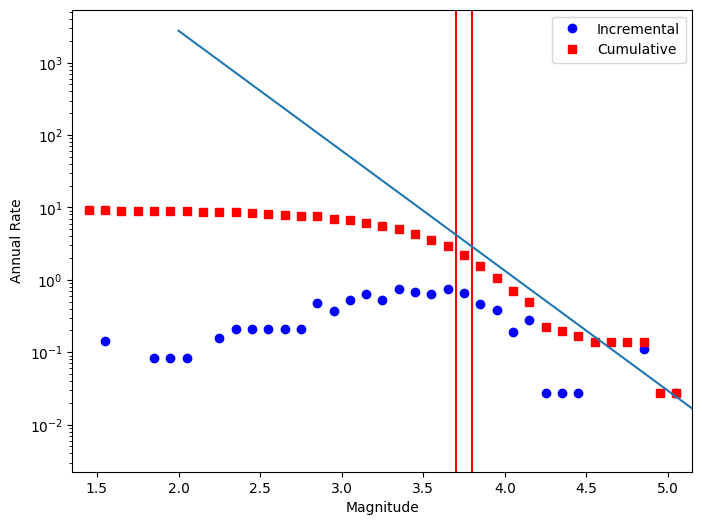

In [18]:
completeness_algorithm = Stepp1971()

comp_config = {'magnitude_bin': 0.1,
                'time_bin': 5. ,
                'increment_lock': True }

completeness_table_old = completeness_algorithm.completeness(catalogue_FaultArea_Depth20km, comp_config)
completeness_algorithm.simplify(mag_range=[2.5, 4.])
completeness_table = completeness_algorithm.completeness_table

print("== Keseluruhan Mc ==")
print(completeness_table_old)
print("\n== selected Mc ==")
print(completeness_table)

mle_config = {'magnitude_interval': 0.1 ,
              'Average Type': 'Weighted',
              'reference_magnitude': None }

recurrence = BMaxLikelihood()

b_val, sigma_b, a_val, sigma_a = recurrence.calculate(catalogue_FaultArea_Depth20km, 
                                                     mle_config, 
                                                     completeness = completeness_table)
print("\n== a dan b value ==")
print("b value = ", b_val, 
      "sigma_b = ", sigma_b, 
      "a value = ", a_val, 
      "sigma_a = ", sigma_a)

m_range = [2., 5.5]
plot_observed_recurrence(catalogue_FaultArea_Depth20km, completeness_table_old, 0.1)
for v in completeness_table[:,1]:
    plt.axvline(v, c="red")
plt.plot(m_range, [10**(a_val-b_val*m_range[0]), 10**(a_val-b_val*m_range[1])])

### 5.2 Megathrust

#### 5.2.1 Konversi data megathrust ke dalam array

In [34]:
# lon lat
txt="""
105.524941802829    -8.71127688943498    5
105.5    -8.59561634597434    5
105.4375    -8.4762705564245    5
105.375    -8.35393314447619    5
105.25    -8.22852433353212    5
105.125    -8.15002416179613    5
104.942927950575    -8.0625    5
104.662433434494    -7.96131262090033    5
104.375    -7.90961738585468    5
104.0625    -7.79665372408826    5
103.78265711955    -7.6875    5
103.655440039067    -7.625    5
103.398213697197    -7.54075699217249    5
103.170158997736    -7.4375    5
103.022944583532    -7.36205741423692    5
102.826375047803    -7.25994336970231    5
102.66822459172    -7.17068831544382    5
102.420973415569    -7.01976860304531    5
"""

# jika delimiter berupa tab maka ubah ke '\t'
delimiter = '    '

def print_array(txt, delimiter):
    txtln = txt.split('\n')
    txtarr = []
    for x in txtln:
        txttemp = [float(t) for t in x.split(delimiter) if t != '']
        if txttemp != []:
            txtarr.append(txttemp)
    print(txtarr)

# execute
print_array(txt, delimiter)

# copy ke variabel
# contoh: upper_megathrust = np.array(<copy di sini>)

[[105.524941802829, -8.71127688943498, 5.0], [105.5, -8.59561634597434, 5.0], [105.4375, -8.4762705564245, 5.0], [105.375, -8.35393314447619, 5.0], [105.25, -8.22852433353212, 5.0], [105.125, -8.15002416179613, 5.0], [104.942927950575, -8.0625, 5.0], [104.662433434494, -7.96131262090033, 5.0], [104.375, -7.90961738585468, 5.0], [104.0625, -7.79665372408826, 5.0], [103.78265711955, -7.6875, 5.0], [103.655440039067, -7.625, 5.0], [103.398213697197, -7.54075699217249, 5.0], [103.170158997736, -7.4375, 5.0], [103.022944583532, -7.36205741423692, 5.0], [102.826375047803, -7.25994336970231, 5.0], [102.66822459172, -7.17068831544382, 5.0], [102.420973415569, -7.01976860304531, 5.0]]


#### 5.2.2 Katalog Megathrust

In [19]:
upper_megathrust = np.array([[105.524941802829, -8.71127688943498, 5.0], [105.5, -8.59561634597434, 5.0], [105.4375, -8.4762705564245, 5.0], [105.375, -8.35393314447619, 5.0], [105.25, -8.22852433353212, 5.0], [105.125, -8.15002416179613, 5.0], [104.942927950575, -8.0625, 5.0], [104.662433434494, -7.96131262090033, 5.0], [104.375, -7.90961738585468, 5.0], [104.0625, -7.79665372408826, 5.0], [103.78265711955, -7.6875, 5.0], [103.655440039067, -7.625, 5.0], [103.398213697197, -7.54075699217249, 5.0], [103.170158997736, -7.4375, 5.0], [103.022944583532, -7.36205741423692, 5.0], [102.826375047803, -7.25994336970231, 5.0], [102.66822459172, -7.17068831544382, 5.0], [102.420973415569, -7.01976860304531, 5.0]])
lower_megathrust = np.array([[106.375, -7.47063188580776, 50.0], [106.209929296531, -7.39061471221387, 50.0], [106.0369736336, -7.29424458268431, 50.0], [105.875, -7.2093622831649, 50.0], [105.737651840558, -7.13915887754735, 50.0], [105.586395412091, -7.0625, 50.0], [105.428038866465, -7.0, 50.0], [105.23019290518, -6.91873613922768, 50.0], [105.090424306723, -6.8313009885949, 50.0], [105.0, -6.76684149798241, 50.0], [104.861944132077, -6.65962175122106, 50.0], [104.75, -6.5709101750316, 50.0], [104.598362254622, -6.46337132188107, 50.0], [104.448382251711, -6.35551336234137, 50.0], [104.329036462161, -6.26807821170859, 50.0], [104.1875, -6.16277310328225, 50.0], [103.949898183528, -6.0, 50.0], [103.707740172221, -5.85011184638015, 50.0]])

edges = [
    LineOQ.from_vectors(upper_megathrust[:,0],upper_megathrust[:,1], deps=upper_megathrust[:,2]),
    LineOQ.from_vectors(lower_megathrust[:,0],lower_megathrust[:,1], deps=lower_megathrust[:,2])
]

megathrust = ComplexFaultSurface.from_fault_data(edges, mesh_spacing=10.)

selector2 = CatalogueSelector(catalogue_declustered, create_copy = True)
catalogue_megathrust = selector2.within_rupture_distance(megathrust, distance=20)

##### 5.2.2.1 Save to pickle variables used by pyGMT

In [20]:
idcs = ['eventID','year','month','day','hour',
       'minute','second','longitude','latitude',
       'depth','magnitude','sigmaMagnitude']

dict_catalogue = dict()
for idx in idcs:
    if isinstance(catalogue[idx], list): 
        dict_catalogue[idx] = catalogue_megathrust[idx]
    else:
        dict_catalogue[idx] = catalogue_megathrust[idx].tolist()
    
with open('dict_catalogue_megathrust.pkl', 'wb') as file:
    pickle.dump(dict_catalogue, file)

dict_megathrust = dict()
dict_megathrust["lon"], dict_megathrust["lat"] = megathrust.get_surface_boundaries()

with open('dict_megathrust.pkl', 'wb') as file:
    pickle.dump(dict_megathrust, file)

#### 5.2.3 Cek Magnitude of Completeness (Mc)  dan a-b value pada area megathrust

== Keseluruhan Mc ==
[[1994.     2.1]
 [1994.     2.2]
 [1994.     2.3]
 [1994.     2.4]
 [1988.     2.5]
 [1984.     2.6]
 [1984.     2.7]
 [1976.     2.8]
 [1976.     2.9]
 [1976.     3. ]
 [1976.     3.1]
 [1976.     3.2]
 [1976.     3.3]
 [1976.     3.4]
 [1976.     3.5]
 [1976.     3.6]
 [1976.     3.7]
 [1976.     3.8]
 [1976.     3.9]
 [1976.     4. ]
 [1976.     4.1]
 [1976.     4.2]
 [1976.     4.3]
 [1976.     4.4]
 [1976.     4.5]
 [1976.     4.6]
 [1976.     4.7]
 [1976.     4.8]
 [1976.     4.9]
 [1976.     5. ]
 [1970.     5.1]
 [1970.     5.2]
 [1970.     5.3]
 [1960.     5.4]
 [1960.     5.5]
 [1959.     5.6]
 [1959.     5.7]
 [1959.     5.8]
 [1959.     5.9]
 [1959.     6. ]
 [1959.     6.1]
 [1959.     6.2]
 [1959.     6.3]
 [1959.     6.4]
 [1959.     6.5]
 [1959.     6.6]]

== selected Mc ==
[[1970.     5.1]
 [1960.     5.4]]
-+- ctime 1970.0  m_c 5.100000000000003
bval:  1.2746057680736873 sigma_b:  0.08394975702352432 neqi:  151 aval:  6.96346302083418 sigma_a:  0

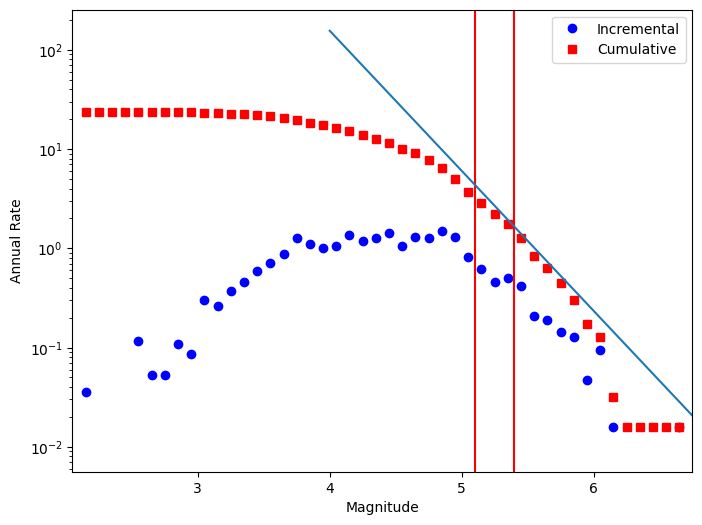

In [21]:
completeness_algorithm = Stepp1971()

comp_config = {'magnitude_bin': 0.1,
                'time_bin': 5. ,
                'increment_lock': True }

completeness_table_old = completeness_algorithm.completeness(catalogue_megathrust, comp_config)
completeness_algorithm.simplify(mag_range=[3., 5.5])
completeness_table = completeness_algorithm.completeness_table

# completeness_table = np.concatenate((completeness_table, Mc_declustered), axis=0)
# completeness_table = Mc_declustered

print("== Keseluruhan Mc ==")
print(completeness_table_old)
print("\n== selected Mc ==")
print(completeness_table)

mle_config = {'magnitude_interval': 0.1 ,
              'Average Type': 'Weighted',
              'reference_magnitude': None }

recurrence = BMaxLikelihood()

b_val, sigma_b, a_val, sigma_a = recurrence.calculate(catalogue_megathrust, 
                                                     mle_config, 
                                                     completeness = completeness_table)
print("\n== a dan b value ==")
print("b value = ", b_val, 
      "sigma_b = ", sigma_b, 
      "a value = ", a_val, 
      "sigma_a = ", sigma_a)

m_range = [4., 7.]
plot_observed_recurrence(catalogue_megathrust, completeness_table_old, 0.1)
for v in completeness_table[:,1]:
    plt.axvline(v, c="red")
plt.plot(m_range, [10**(a_val-b_val*m_range[0]), 10**(a_val-b_val*m_range[1])])

### 5.3 Shallow Background

#### 5.3.1 Fungsi menghilangkan data yang berada di katalog lain

In [22]:
def remove_events_in_A_from_B(catalogue_A, catalogue_B):
    selector1 = CatalogueSelector(catalogue_A)
    flags = ~np.in1d(catalogue_A.data['eventID'], catalogue_B.data['eventID'])
    catalogue_C = selector1.select_catalogue(flags)
    return catalogue_C

#### 5.3.2 Batasi data pada daerah shallow background

In [23]:
x = [103.4,103.4,105.98,105.98]
y = [-6.345,-3.563,-3.563,-6.345]
polyAreaBg = PolyOQ([PointOQ(lon, lat) for lon, lat in zip(x, y)])

catalogue_ShallowBackground_Depth20km = copy_cutPoly_cutDepth(catalogue_declustered, polyAreaBg, 20)

catalogue_ShallowBackground_Depth20km_filtered1 = remove_events_in_A_from_B(catalogue_ShallowBackground_Depth20km, catalogue_FaultArea_Depth20km)
catalogue_ShallowBackground_Depth20km_filtered2 = remove_events_in_A_from_B(catalogue_ShallowBackground_Depth20km_filtered1, catalogue_megathrust)

#### 5.3.3 Simpan variabel untuk dipakai di pyGMT

In [24]:
idcs = ['eventID','year','month','day','hour',
       'minute','second','longitude','latitude',
       'depth','magnitude','sigmaMagnitude']

dict_catalogue = dict()
for idx in idcs:
    if isinstance(catalogue[idx], list): 
        dict_catalogue[idx] = catalogue_ShallowBackground_Depth20km_filtered2[idx]
    else:
        dict_catalogue[idx] = catalogue_ShallowBackground_Depth20km_filtered2[idx].tolist()
    
with open('dict_catalogue_shallowbackground.pkl', 'wb') as file:
    pickle.dump(dict_catalogue, file)

dict_shallowbackground = dict()
dict_shallowbackground["lon"], dict_shallowbackground["lat"] = np.array(polyAreaBg.coords)[:,0], np.array(polyAreaBg.coords)[:,1]

with open('dict_shallowbackground.pkl', 'wb') as file:
    pickle.dump(dict_shallowbackground, file)

#### 5.3.4 Cek Magnitude of Completeness (Mc)  dan a-b value pada area shallow background

== Keseluruhan Mc ==
[[2.005e+03 1.700e+00]
 [2.005e+03 1.800e+00]
 [2.005e+03 1.900e+00]
 [1.984e+03 2.000e+00]
 [1.984e+03 2.100e+00]
 [1.984e+03 2.200e+00]
 [1.984e+03 2.300e+00]
 [1.984e+03 2.400e+00]
 [1.984e+03 2.500e+00]
 [1.984e+03 2.600e+00]
 [1.984e+03 2.700e+00]
 [1.984e+03 2.800e+00]
 [1.984e+03 2.900e+00]
 [1.984e+03 3.000e+00]
 [1.984e+03 3.100e+00]
 [1.984e+03 3.200e+00]
 [1.984e+03 3.300e+00]
 [1.984e+03 3.400e+00]
 [1.984e+03 3.500e+00]
 [1.984e+03 3.600e+00]
 [1.984e+03 3.700e+00]
 [1.984e+03 3.800e+00]
 [1.984e+03 3.900e+00]
 [1.984e+03 4.000e+00]
 [1.984e+03 4.100e+00]
 [1.984e+03 4.200e+00]
 [1.984e+03 4.300e+00]
 [1.984e+03 4.400e+00]
 [1.982e+03 4.500e+00]
 [1.982e+03 4.600e+00]
 [1.982e+03 4.700e+00]
 [1.978e+03 4.800e+00]
 [1.978e+03 4.900e+00]
 [1.978e+03 5.000e+00]
 [1.978e+03 5.100e+00]
 [1.978e+03 5.200e+00]
 [1.978e+03 5.300e+00]
 [1.978e+03 5.400e+00]
 [1.978e+03 5.500e+00]]

== selected Mc ==
[[1982.     4.5]
 [1978.     4.8]]
-+- ctime 1982.0  m_c 4.500

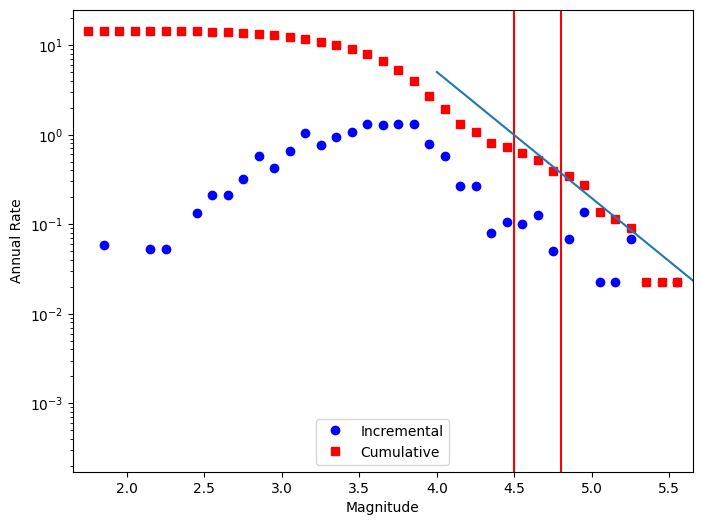

In [25]:
completeness_algorithm = Stepp1971()

comp_config = {'magnitude_bin': 0.1,
                'time_bin': 5. ,
                'increment_lock': True }

completeness_table_old = completeness_algorithm.completeness(catalogue_ShallowBackground_Depth20km_filtered2, comp_config)
completeness_algorithm.simplify(mag_range=[3., 5.])
completeness_table = completeness_algorithm.completeness_table

# completeness_table = np.concatenate((completeness_table, Mc_declustered), axis=0)
# completeness_table = Mc_declustered

print("== Keseluruhan Mc ==")
print(completeness_table_old)
print("\n== selected Mc ==")
print(completeness_table)

mle_config = {'magnitude_interval': 0.1 ,
              'Average Type': 'Weighted',
              'reference_magnitude': None }

recurrence = BMaxLikelihood()

b_val, sigma_b, a_val, sigma_a = recurrence.calculate(catalogue_ShallowBackground_Depth20km_filtered2, 
                                                     mle_config, 
                                                     completeness = completeness_table)
print("\n== a dan b value ==")
print("b value = ", b_val, 
      "sigma_b = ", sigma_b, 
      "a value = ", a_val, 
      "sigma_a = ", sigma_a)

m_range = [4., 7.]
plot_observed_recurrence(catalogue_ShallowBackground_Depth20km_filtered2, completeness_table_old, 0.1)
for v in completeness_table[:,1]:
    plt.axvline(v, c="red")
plt.plot(m_range, [10**(a_val-b_val*m_range[0]), 10**(a_val-b_val*m_range[1])])